# Lista 2
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)
___

## Importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from matplotlib.lines import Line2D
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = "1"

___
## Zadanie 1
W zadaniu wygenerowano syntetyczny zbiór danych z trzema skupieniami za pomocą funkcji `make_blobs` z biblioteki `scikit-learn`. Wynik został przedstawiony na wykresie punktowym, który pokazuje trzy wyraźnie oddzielone grupy punktów.

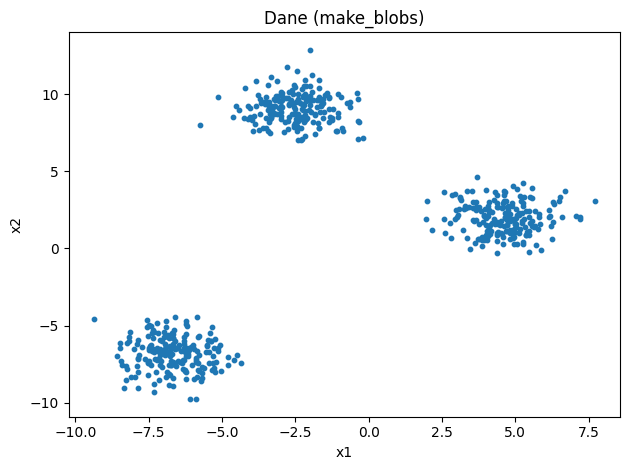

In [2]:
X, y_true = make_blobs(
    n_samples=600, centers=3, n_features=2,
    cluster_std=1, random_state=42
)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Dane (make_blobs)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

___
## Zadanie 2
W zadaniu zaimplementowano algorytm k-means przedstawiony na wykładzie. Centroidy zostały wylosowane spośród istniejących obserwacji, a iteracyjny proces aktualizacji trwa do momentu, gdy zmiany pozycji są mniejsze od zadanej tolerancji lub osiągnięto maksymalną liczbę iteracji.

Algorytm minimalizuje sumę kwadratów odległości punktów od przypisanych im centroidów (SSE), co jest jego funkcją celu. Wynik końcowy to etykiety klastrów, współrzędne centroidów oraz wartość SSE. Wyniki zaprezentowano na wykresie, na którym widać trzy wyraźne skupienia oraz odpowiadające im centroidy.

[Scratch] SSE: 1160.90


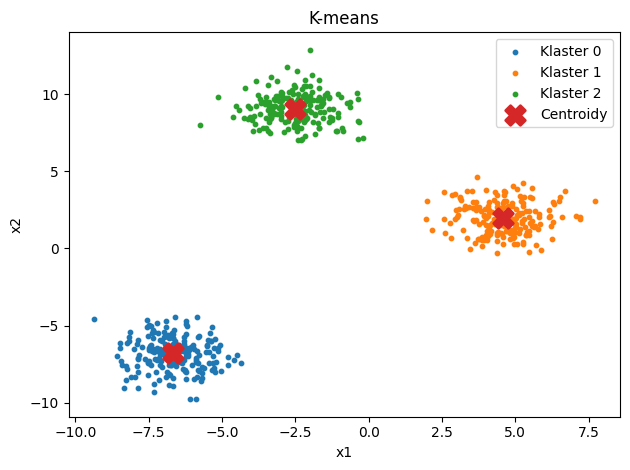

In [3]:
def kmeans_simple(X, k, max_iter=100, tol=1e-4, seed=42):
    rng = np.random.default_rng(seed)
    C = X[rng.choice(len(X), k, replace=False)].astype(float)  # losowe centroidy

    for _ in range(max_iter):
        # przypisania: najbliższy centroid (L2)
        d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
        labels = d2.argmin(axis=1)

        # aktualizacja: średnia punktów w każdym klastrze
        newC = np.vstack([
            X[labels == i].mean(axis=0) if np.any(labels == i) else C[i]
            for i in range(k)
        ])

        # stop, gdy centroidy prawie się nie zmieniają
        if np.linalg.norm(newC - C) <= tol:
            C = newC
            break
        C = newC

    # SSE (funkcja celu)
    sse = float(((X - C[labels]) ** 2).sum())
    return labels, C, sse


labels_s, centers_s, sse_s = kmeans_simple(X, k=3, max_iter=100, tol=1e-4, seed=7)
print(f"[Scratch] SSE: {sse_s:.2f}")

plt.figure()
for i in range(3):
    pts = X[labels_s == i]
    plt.scatter(pts[:, 0], pts[:, 1], s=10, label=f"Klaster {i}")
plt.scatter(centers_s[:, 0], centers_s[:, 1], marker="X", s=200, linewidths=2, label="Centroidy")
plt.title("K-means")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()

___
## Zadanie 3
W tym zadaniu wykorzystano gotową implementację algorytmu k-means z klasy `KMeans` biblioteki `scikit-learn` do grupowania danych wygenerowanych wcześniej. Po wykonaniu dopasowania metodą `fit_predict` otrzymano etykiety klastrów oraz wartość funkcji celu (SSE), określoną w bibliotece jako `inertia_`.

[sklearn] SSE (inertia): 1160.90
Różnica SSE (scratch - sklearn): 0.00


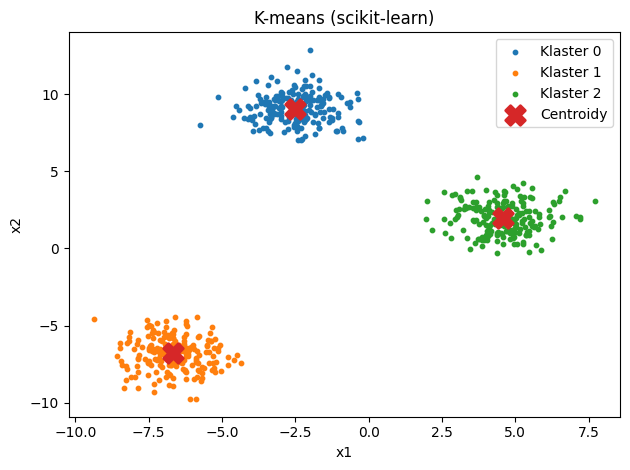

In [4]:
km = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_lib = km.fit_predict(X)
print(f"[sklearn] SSE (inertia): {km.inertia_:.2f}")
print(f"Różnica SSE (scratch - sklearn): {sse_s - km.inertia_:.2f}")

plt.figure()
for i in range(3):
    pts = X[labels_lib == i]
    plt.scatter(pts[:, 0], pts[:, 1], s=10, label=f"Klaster {i}")
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker="X", s=200, linewidths=2, label="Centroidy")
plt.title("K-means (scikit-learn)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()

Obie wersje k-means dają praktycznie identyczny podział i centroidy. To naturalne, bo k-means minimalizuje SSE i dla trzech, kulistych, wyraźnie rozdzielonych chmur oba algorytmy zbiegają do tego samego minimum. 

___
## Zadanie 4
W zadaniu zastosowano algorytm klastrowania hierarchicznego metodą aglomeracyjną (`AgglomerativeClustering`) do danych syntetycznych z trzech skupień. Wykorzystano cztery różne miary łączenia klastrów (`linkage`): *single*, *complete*, *average* i *ward*, a następnie porównano ich efekty wizualnie za pomocą dendrogramów i wykresów punktowych.

Dendrogramy pokazują, w jaki sposób algorytm łączy punkty w coraz większe grupy — od pojedynczych obserwacji aż po jeden klaster obejmujący cały zbiór.

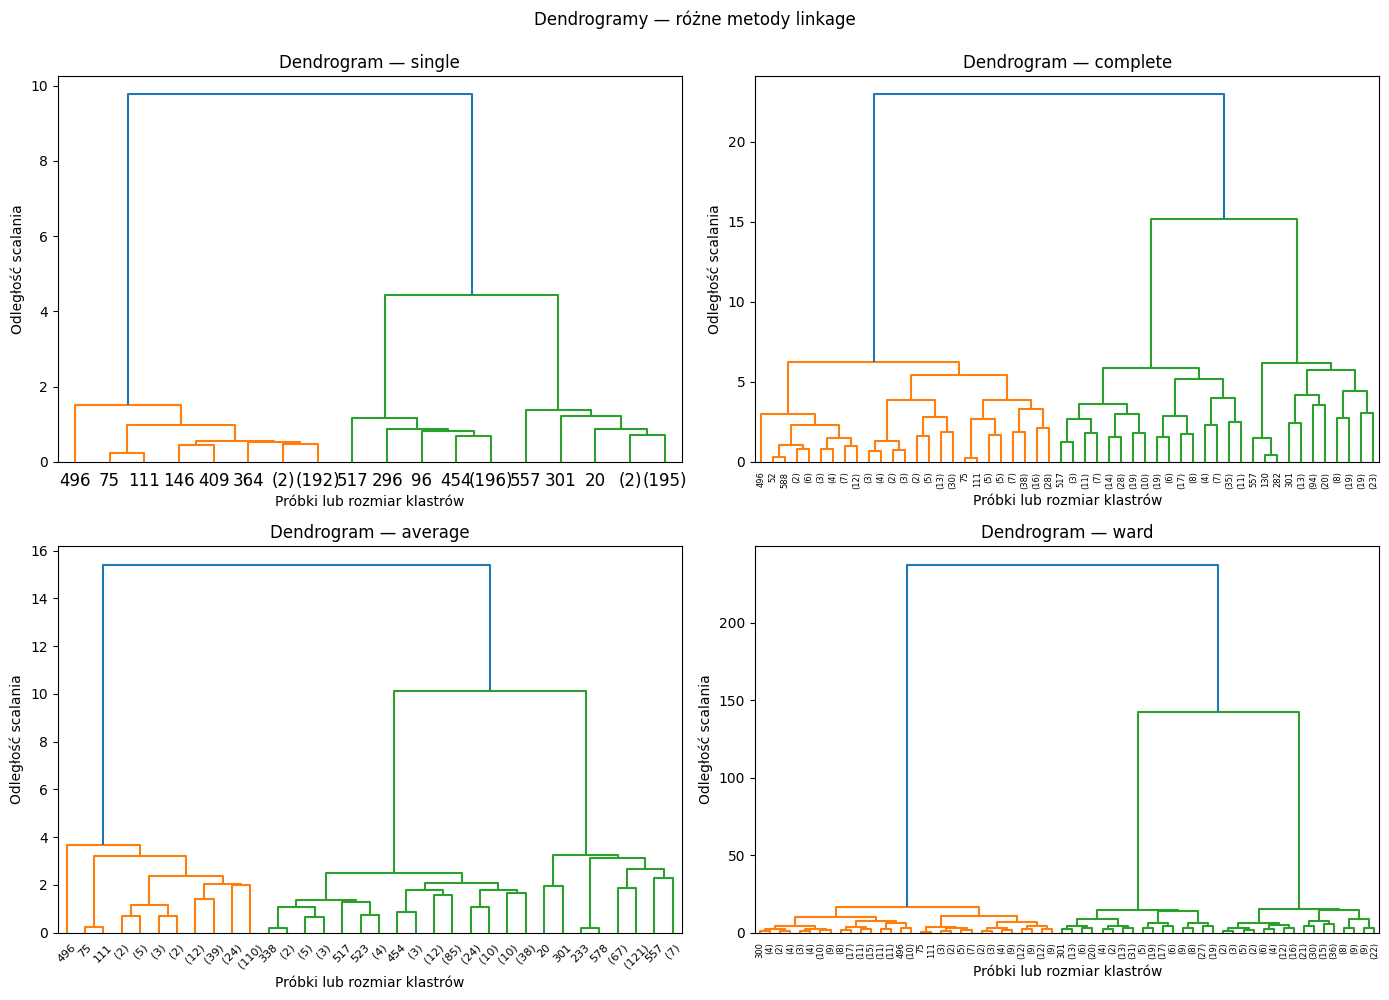

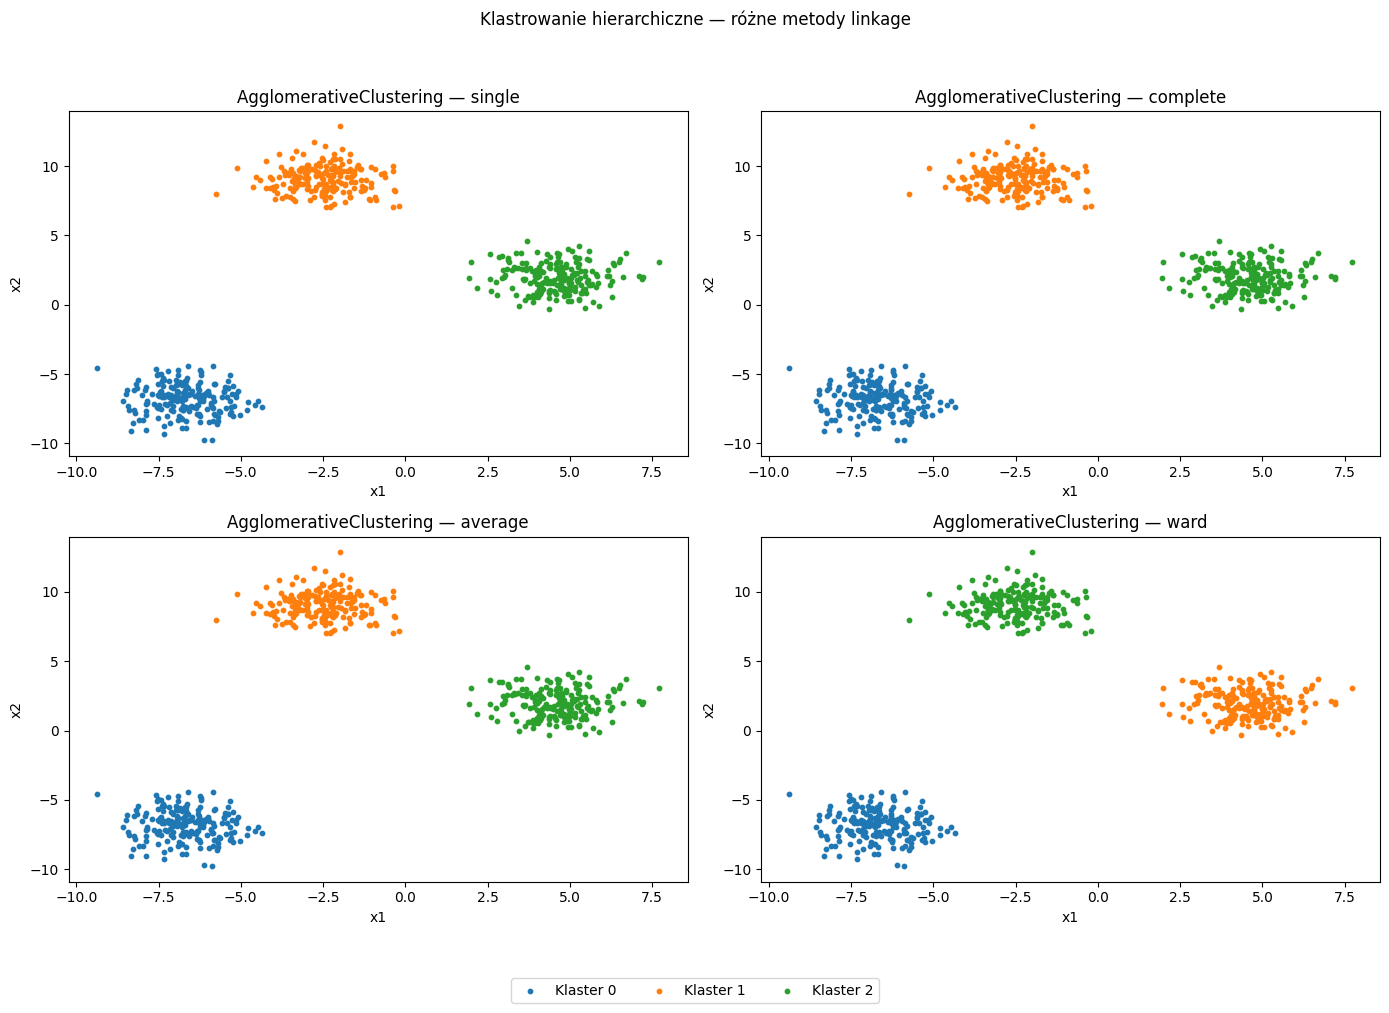

In [ ]:
X, _ = make_blobs(n_samples=600, centers=3, n_features=2,
                  cluster_std=1.0, random_state=42)

methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, method in zip(axes.ravel(), methods):
    Z = linkage(X, method=method)  
    dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_title(f"Dendrogram — {method}")
    ax.set_xlabel("Próbki lub rozmiar klastrów")
    ax.set_ylabel("Odległość scalania")

fig.suptitle("Dendrogramy — różne metody linkage", y=0.995)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, method in zip(axes.ravel(), methods):
    model = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = model.fit_predict(X)
    for lab in np.unique(labels):
        pts = X[labels == lab]
        ax.scatter(pts[:, 0], pts[:, 1], s=10, label=f"Klaster {lab}")
    ax.set_title(f"AgglomerativeClustering — {method}")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

handles, labels_ = axes.ravel()[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=6, bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Klastrowanie hierarchiczne — różne metody linkage", y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
plt.show()


Na naszych danych mamy trzy wyraźne, kuliste i daleko od siebie położone chmury, więc niezależnie od metody łączenia (single/complete/average/ward) `AgglomerativeClustering` z `n_clusters = 3` zwraca ten sam podział – dlatego scattery wyglądają praktycznie identycznie. Różnice widać dopiero na dendrogramach: `single` scala na najniższych wysokościach (bierze najbliższą parę, więc jest podatny na „łańcuchowanie”), `complete` scala na dużo wyższych (patrzy na najdalszą parę i preferuje zwięzłe klastry), `average` jest pośrodku, a `ward` minimalizuje wzrost wariancji wewnątrz klastrów, przez co ostatnie zlania są najwyższe i zwykle pokazują bardzo wyraźny skok między klastrami 3 i 2. Innymi słowy: przy „łatwych” danych wybór linkage nie zmienia ostatecznej etykiety klastra dla `k = 3`, ale zmienia kolejność i wysokości zlewań na drzewie; gdyby chmury były podłużne lub blisko siebie, metoda łączenia mogłaby wpływać także na końcowy podział.

___
## Zadanie 5

W zadaniu oceniono jakość klastrowania dla zbioru **Iris**, stosując dwie klasyczne metody: **metodę łokcia** oraz **wskaźnik Silhouette**. Dane zostały znormalizowane, co jest istotne, ponieważ różne skale cech mogą zaburzać wyniki algorytmu k-means.

Metoda łokcia polega na analizie wartości sumy kwadratów odległości punktów od ich centroidów (SSE) w zależności od liczby klastrów. Wykres zazwyczaj pokazuje punkt załamania — tzw. „łokieć” — który wskazuje, że dalsze zwiększanie liczby klastrów nie przynosi już istotnego spadku błędu.

Wskaźnik Silhouette mierzy spójność i separację klastrów; jego wartość mieści się w przedziale ([-1, 1]), gdzie wyższe wartości oznaczają lepsze dopasowanie. Optymalna liczba klastrów odpowiada maksimum tej miary.

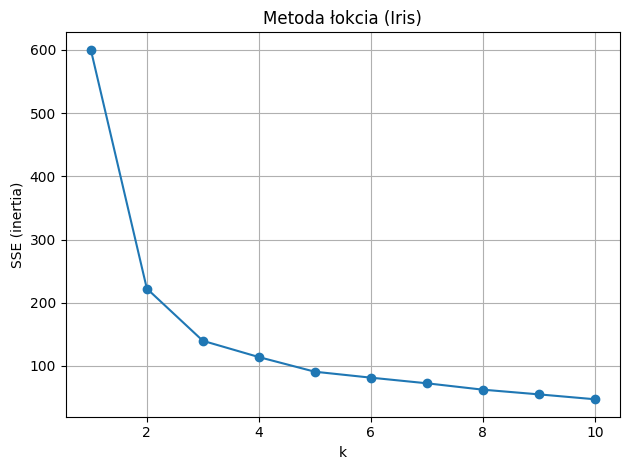

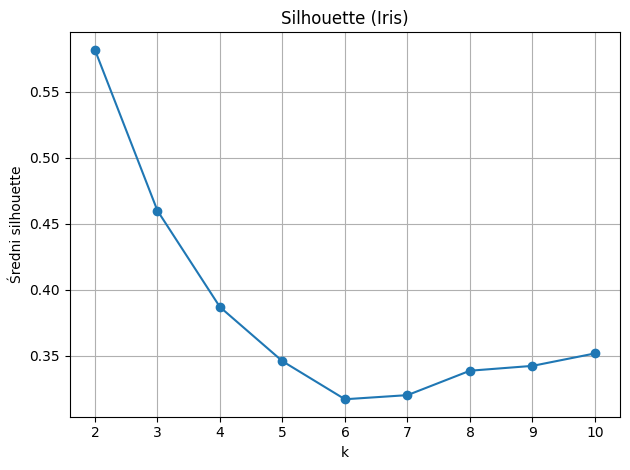

In [6]:
USE_SCALING = True
iris = load_iris()
X = iris.data
if USE_SCALING:
    X = StandardScaler().fit_transform(X)

def elbow_method(X, max_k=10):
    sse = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        if k == 1:
            sse.append(float(np.sum((X - X.mean(axis=0))**2)))
        else:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(X)
            sse.append(float(km.inertia_))
    return list(k_range), sse

def silhouette_analysis(X, max_k=10):
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        silhouette_scores.append(float(silhouette_score(X, labels)))
    return list(k_range), silhouette_scores

ks_elbow, sse = elbow_method(X, max_k=10)
ks_sil, sil = silhouette_analysis(X, max_k=10)

plt.figure()
plt.plot(ks_elbow, sse, marker='o')
plt.title("Metoda łokcia (Iris)")
plt.xlabel("k")
plt.ylabel("SSE (inertia)")
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(ks_sil, sil, marker='o')
plt.title("Silhouette (Iris)")
plt.xlabel("k")
plt.ylabel("Średni silhouette")
plt.tight_layout()
plt.grid(True)
plt.show()


Na wykresie łokcia widać gwałtowny spadek SSE do okolic k=3, po czym krzywa wyraźnie się „prostuje” – klasyczny łokieć sugeruje 3 skupienia i to pasuje do faktu, że w bazie danych **Iris** są trzy gatunki kwiatów. Na wykresie silhouette maksimum wypada przy k=2. Dzieje się tak, ponieważ silhouette nagradza duży odstęp między klastrami i wysoką spójność. 

___
## Zadanie 6

W zadaniu zastosowano algorytm **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** do grupowania danych syntetycznych. Celem było zbadanie wpływu parametrów `eps` (promień sąsiedztwa) i `min_samples` (minimalna liczba punktów w sąsiedztwie) na wyniki klastrowania oraz identyfikację punktów uznanych za „szum”.

DBSCAN grupuje punkty na podstawie gęstości — punkty wewnątrz obszarów o dużym zagęszczeniu tworzą klastry, natomiast punkty odizolowane traktowane są jako odstające (oznaczane etykietą `-1`).

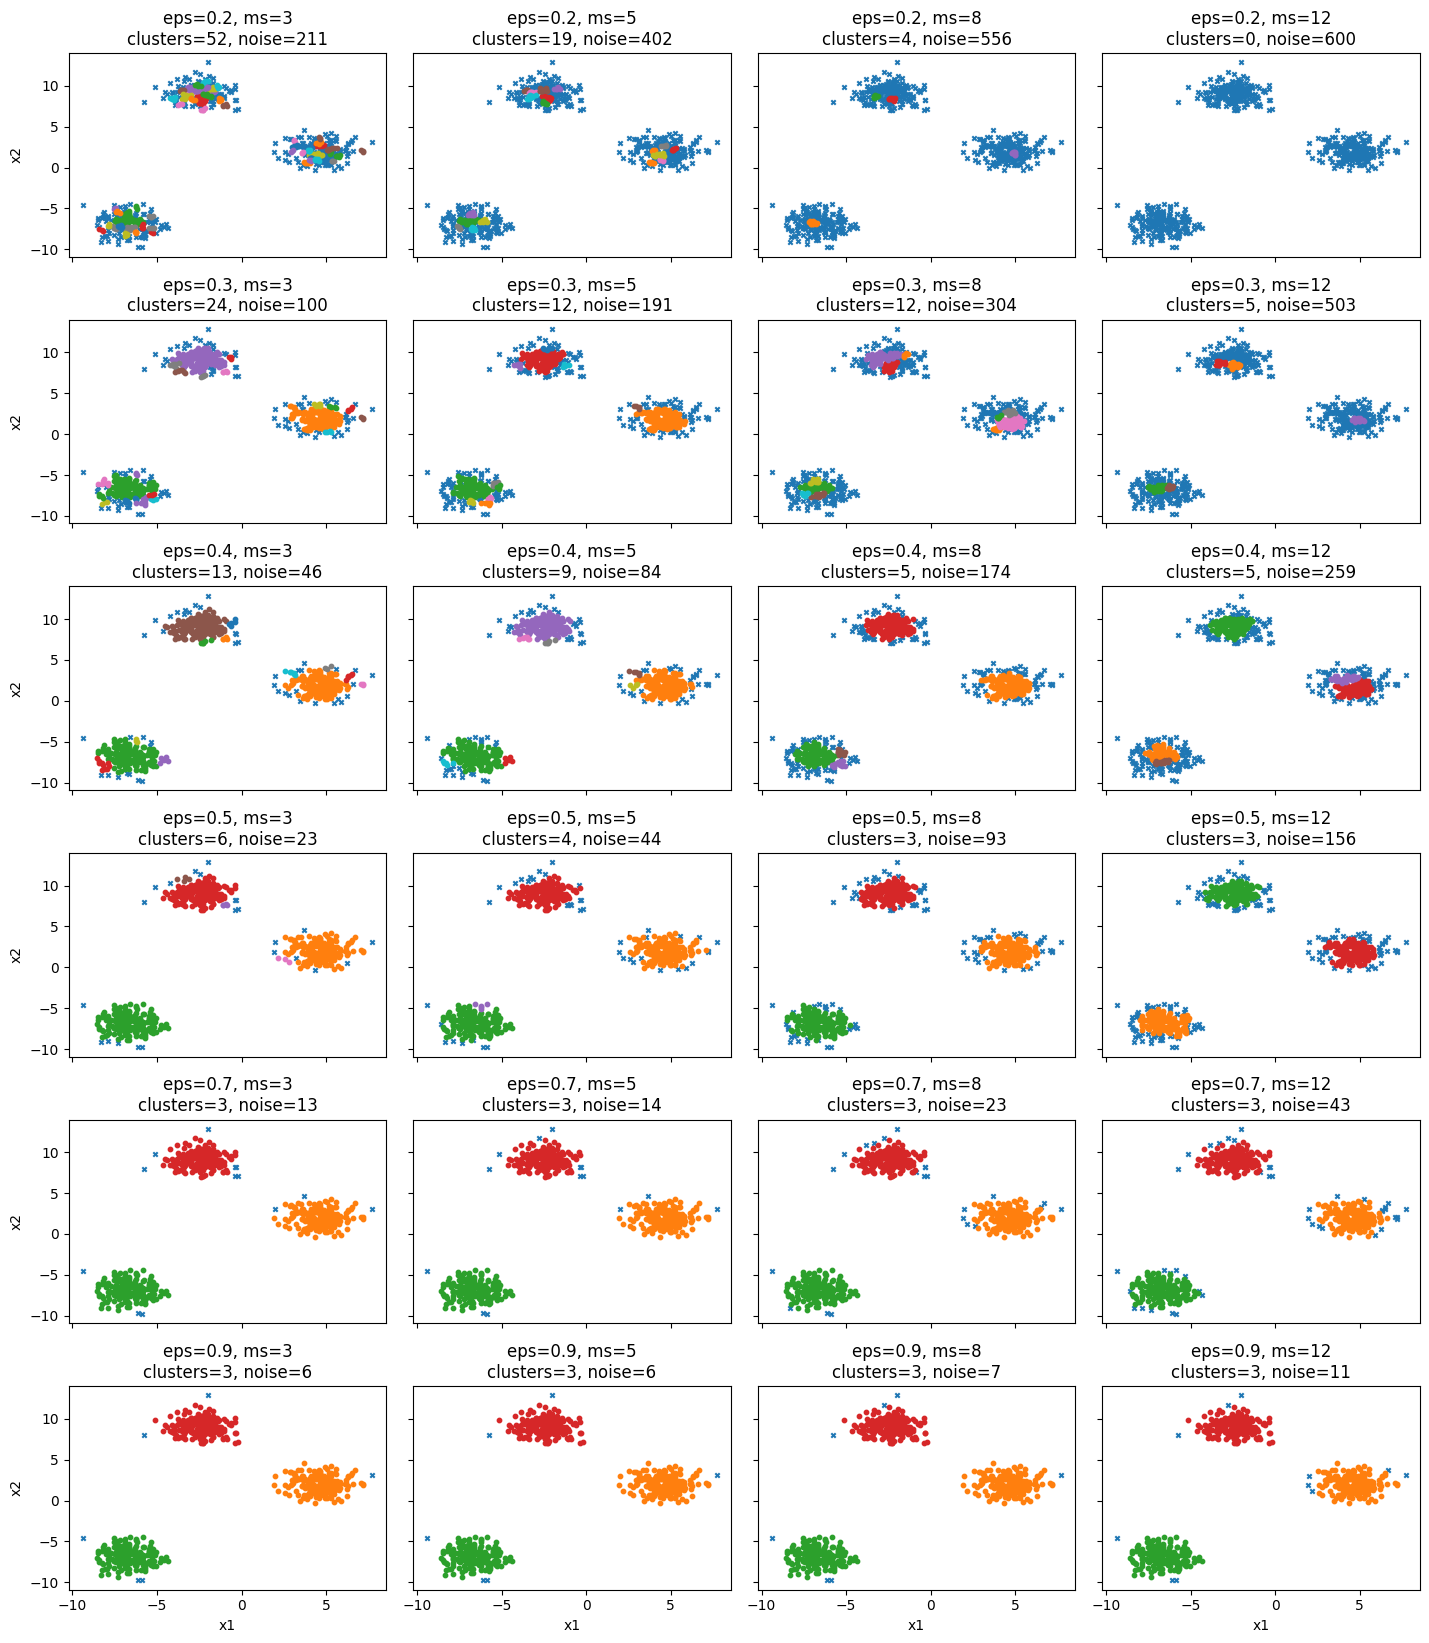

In [ ]:
X, _ = make_blobs(n_samples=600, centers=3, n_features=2,
                  cluster_std=1.0, random_state=42)

eps = [0.20, 0.30, 0.40, 0.50, 0.70, 0.90]  
min_samples = [3, 5, 8, 12]                 

n_rows, n_cols = len(eps), len(min_samples)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(3.6*n_cols, 2.9*n_rows),
                         sharex=True, sharey=True)

axes = np.atleast_2d(axes)

for i, eps in enumerate(eps):
    for j, ms in enumerate(min_samples):
        ax = axes[i, j]
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        n_noise = int(np.sum(labels == -1))
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        #klastry = 'o', szum = 'x'
        unique = sorted(set(labels))
        for lab in unique:
            mask = labels == lab
            if lab == -1:
                ax.scatter(X[mask, 0], X[mask, 1], s=10, marker='x', label="Szum (-1)")
            else:
                ax.scatter(X[mask, 0], X[mask, 1], s=10, label=f"Klaster {lab}")

        ax.set_title(f"eps={eps}, ms={ms}\nclusters={n_clusters}, noise={n_noise}")
        if i == n_rows - 1:
            ax.set_xlabel("x1")
        if j == 0:
            ax.set_ylabel("x2")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Analiza różnych kombinacji parametrów pokazuje, że:
– zbyt mała wartość `eps` prowadzi do powstania wielu małych klastrów i dużej liczby punktów szumu,
– zbyt duża wartość `eps` powoduje łączenie odrębnych grup w jeden klaster,
– zwiększenie `min_samples` sprawia, że algorytm staje się bardziej „konserwatywny” i częściej oznacza punkty jako szum.

Wizualizacje poprawnie ilustrują te zależności — przy odpowiednich parametrach DBSCAN poprawnie rozpoznaje trzy skupienia i wyodrębnia pojedyncze punkty odstające.

___
## Zadanie 7
W zadaniu przeprowadzono analizę skupień na rzeczywistym zbiorze danych **Mall Customer Segmentation Data**, który zawiera informacje o klientach centrum handlowego. Do klastrowania wykorzystano dwie cechy: **wiek** oraz **roczny dochód**, co pozwala na identyfikację grup klientów o podobnym profilu demograficzno-finansowym.

In [8]:
df = pd.read_csv(r"Datasets/Mall_Customers.csv")
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Na początek dane zostały wstępnie sprawdzone pod kątem braków.

In [9]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Następnie wybrane zostały odpowiednie cechy.

In [10]:
features = ["Age", "Annual Income (k$)"]
X_raw = df[features].to_numpy()

W następniej kolejności dane zostały standaryzowane przy użyciu `StandardScaler`, co jest konieczne, ponieważ obie zmienne mają różne skale.

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

Następnie wykorzystano metodę łokcia i wskaźnik silhouette do wyznaczenia odpowiedniej liczby klastrów.

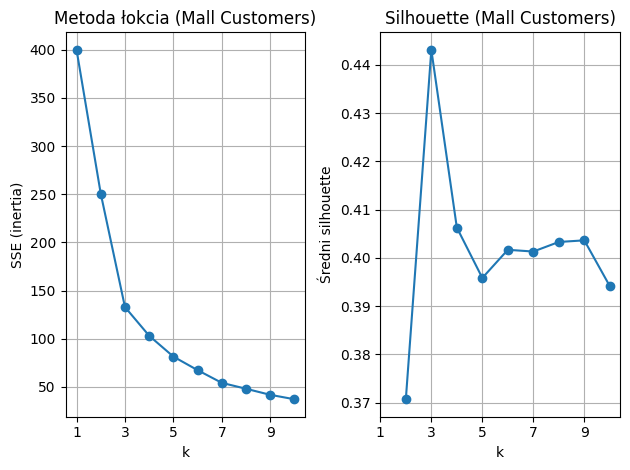

In [12]:
ks_elbow_mall, sse_mall = elbow_method(X, max_k=10)
ks_sil_mall, sil_mall = silhouette_analysis(X, max_k=10)

plt.subplot(1, 2, 1)
plt.plot(ks_elbow_mall, sse_mall, marker='o')
plt.title("Metoda łokcia (Mall Customers)")
plt.xlabel("k")
plt.xticks([k for k in ks_elbow_mall if k % 2 == 1])
plt.ylabel("SSE (inertia)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ks_sil_mall, sil_mall, marker='o')
plt.title("Silhouette (Mall Customers)")
plt.xlabel("k")
plt.xticks([k for k in ks_elbow_mall if k % 2 == 1])
plt.ylabel("Średni silhouette")
plt.grid(True)

plt.tight_layout()
plt.show()

Obie metody wskazały, że odpowiednią liczbą klastrów jest 3. Zastosowano więc algorytm **k-means** z ` k = 3 `.

Wyniki zaprezentowano w formie wykresu punktowego i tabeli. Centroidy odzwierciedlają średnie wartości wieku i dochodu w każdej grupie, co pozwala zinterpretować segmenty klientów.

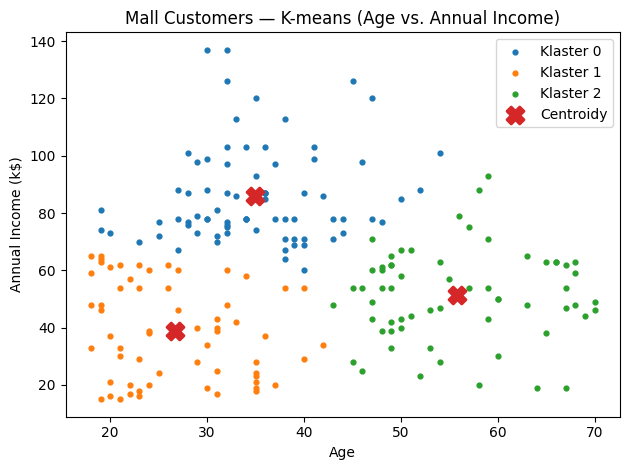

,Cluster,Age_mean,Income_k$_mean,Size
0,0,35.0,85.9,76
1,1,26.7,38.8,62
2,2,55.8,51.2,62


In [ ]:
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = km.fit_predict(X)
centers = scaler.inverse_transform(km.cluster_centers_)

plt.figure()
for i in range(k):
    pts = X_raw[labels == i]
    plt.scatter(pts[:, 0], pts[:, 1], s=12, label=f"Klaster {i}")
plt.scatter(centers[:, 0], centers[:, 1], marker="X", s=150, linewidths=2, label="Centroidy")
plt.title("Mall Customers — K-means (Age vs. Annual Income)")
plt.xlabel("Age"); plt.ylabel("Annual Income (k$)")
plt.legend(); plt.tight_layout(); plt.show()

sizes = pd.Series(labels).value_counts().sort_index()
summary = pd.DataFrame({
    "Cluster": np.arange(k),
    "Age_mean": centers[:, 0].round(1),
    "Income_k$_mean": centers[:, 1].round(1),
    "Size": sizes.values
})

summary

- Klaster 0: średni wiek klientów z wyższym dochodem (~35 lat, ~$86k) - największa grupa.

- Klaster 1: klienci w najniższym wieku z niskim dochodem (~27 lat, ~$39k).

- Klaster 2: starsza grupa o średnim dochodzie (~56 lat, ~$51k).

Wizualizacja pokazuje trzy dość naturalne segmenty. Taki podział może być bazą do różnicowania ofert (np. budżet vs premium) w zależności od wieku i dochodu.